# MetaTuner on the breast cancer dataset serial


# Load the Dataset

In [1]:
from scipy.stats import uniform

In [2]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


bcancer = datasets.load_breast_cancer()
X = bcancer.data
Y = bcancer.target

# XgBoost

In [3]:
from xgboost import XGBClassifier

param_dict_xgboost = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1, 15),
              "n_estimators": range(1, 3),
               "booster":['gbtree','gblinear','dart']
             }


X_xgboost = X 
Y_xgboost = Y

# import warnings
# warnings.filterwarnings('ignore')

def objective_xgboost(args_list):
    global X_xgboost, Y_xgboost

    results = []
    for hyper_par in args_list:
        #clf = XGBClassifier(**hyper_par)
        clf = XGBClassifier(verbosity = 0, random_state = 0)
        
        #clf = XGBClassifier()
        clf.set_params(**hyper_par)

        result = cross_val_score(clf, X_xgboost, Y_xgboost, scoring='accuracy', cv=3).mean()
        results.append(result)
    return results

# KNN

In [4]:
param_dict_knn = {"n_neighbors": range(1, 100),
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }
X_knn = X
Y_knn = Y

def objective_knn(args_list):
    global X_knn,Y_knn
    
    results = []
    for hyper_par in args_list:
        clf = KNeighborsClassifier()
        
        clf.set_params(**hyper_par)
        
        result  = cross_val_score(clf, X_knn, Y_knn, scoring='accuracy', cv=3).mean()
        results.append(result)
    return results


# SVM

In [5]:
from mango.domain.distribution import loguniform
from sklearn import svm

param_dict_svm = {"gamma": uniform(0.1, 4),
              "C": loguniform(-7, 10)}

X_svm = X 
Y_svm = Y


def objective_svm(args_list):
    global X_svm,Y_svm
    
    results = []
    for hyper_par in args_list:
        clf = svm.SVC(random_state = 0)
        
        clf.set_params(**hyper_par)
        
        result  = cross_val_score(clf, X_svm, Y_svm, scoring='accuracy', cv= 3).mean()
        results.append(result)
    return results

# Neural Network

In [6]:
param_space_nn = dict(num_of_nodes=range(10, 1000))

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model(num_of_nodes):
    global X_nn, Y_nn
    model = Sequential()
    #model.add(Dense(4, input_dim=X.shape[1], activation='relu'))
    # Hidden dimension of layers = num_of_nodes
    model.add(Dense(num_of_nodes, input_dim=X_nn.shape[1], activation='relu'))
        
    model.add(Dense(Y_nn.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
    
    return model

from keras.utils import np_utils


X_nn = X 
Y_nn = np_utils.to_categorical(Y, 2)

print(Y_nn.shape)

def objective_nn(args_list):
    global X_nn, Y_nn
    
    results  = []
    for hyper_par in args_list:
        
        model = get_model(**hyper_par)

        #train the clf.
        model.fit(X_nn, Y_nn,
              batch_size=32,
              epochs=10,
              verbose=0)

        score = model.evaluate(X_nn,Y_nn, verbose=0)
        
        results.append(score[1])
    
   
    return results

(569, 2)


Using TensorFlow backend.


# Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

param_dict_dtree = {
              "max_features": ['auto', 'sqrt', 'log2'],
               "max_depth": range(1,20),     
               "splitter":['best','random'],
               "criterion":['gini','entropy']
             }


X_dtree = X 
Y_dtree = Y

print(X_dtree.shape, Y_dtree.shape)

def objective_dtree(args_list):
    global X_dtree,Y_dtree
    
    results = []
    for hyper_par in args_list:
        clf =  DecisionTreeClassifier(random_state = 0)
        
        clf.set_params(**hyper_par)
        result  = cross_val_score(clf, X_dtree, Y_dtree, scoring='accuracy', cv=3).mean()
        results.append(result)
    return results

(569, 30) (569,)


In [8]:
param_space_list = [param_dict_knn, param_dict_svm, param_space_nn, param_dict_dtree, param_dict_xgboost]
objective_list = [objective_knn, objective_svm, objective_nn, objective_dtree, objective_xgboost]

In [9]:
objective_values = []

from mango import MetaTuner
import numpy as np
import random

# seed = 0
# tensorflow.set_random_seed(seed)


for seed in range(5):
    np.random.seed(seed)
    random.seed(seed)
    
    metatuner = MetaTuner(param_space_list, objective_list)
    metatuner.seed = seed
    
    metatuner.num_of_iterations = 100
    metatuner.initial_random = 2
    metatuner.run()
    
    objective_values.append(metatuner.objective_values_list)
       

# Save the Results

In [10]:
import pickle

with open('data/MetaTune_bcancer_serial.pickle', 'wb') as f:
    pickle.dump(objective_values, f)

In [11]:
# Load the data

import pickle
with open('data/MetaTune_bcancer_serial.pickle', 'rb') as f:
    objective_values = pickle.load(f)

# Plot the max function variations

In [12]:
import numpy as np

objective_values = np.array(objective_values)

In [13]:
objective_values.shape

(5, 110)

In [14]:
results_variation = []

for j in range(objective_values.shape[0]):
    values = []
    for i in range(objective_values.shape[1]):
        val = np.max(objective_values[j,:(i+10)])
        #print(j,i,val)
        values.append(val)
    
    results_variation.append(values)
        

In [15]:
all_results_variation = np.array(results_variation)

print(all_results_variation.shape)

(5, 110)


In [16]:
avg_tuner = np.mean(all_results_variation,axis = 0)
min_tuner = np.min(all_results_variation,axis = 0)
max_tuner = np.max(all_results_variation,axis = 0)

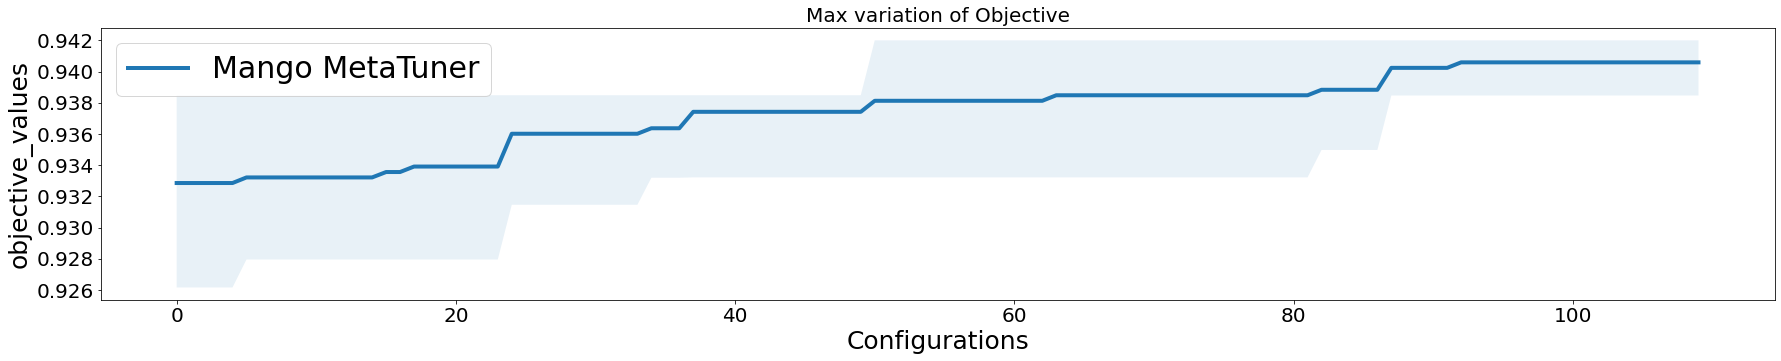

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Max variation of Objective',fontsize=20)

configs = [i for i in range(all_results_variation.shape[1])]

plt.plot(configs, avg_tuner,lw=4,label='Mango MetaTuner')


plt.fill_between(configs, min_tuner, max_tuner, alpha=0.1)

plt.xlabel('Configurations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()